### Instalation

In [1]:
# !pip3 install git+https://gitlab.gwdg.de/irp/hotopy.git --user
# !pip install sscResolution==0.6.1
# !pip install sscFresnel --index-url https://gitlab.cnpem.br/api/v4/projects/3492/packages/pypi/simple

## LINK
## https://cnpemcamp-my.sharepoint.com/:x:/g/personal/larissa_moreno_lnls_br/EUGAtGsuTrFGp8LYZvEOH34BsYhuZOHHnOKxcqagjQEp2g?e=8UmnS9

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.linalg as spy
import h5py
import cv2

import sscFresnel
import tomopy
from hotopy.phase import CTF, Tikhonov, Constraints
import sscResolution

c = 299792458               
plank = 4.135667662E-15    
CONST = plank * c
DEVICE = 'cpu'
GPUS = [0]
CPUS = 32

#### Utils

In [2]:
def print_fig(x, names = None):
    n = len(x)
    
    fig, ax_ = plt.subplots(1,n, figsize = (10*n,8*n))
    if(n == 1):
        ax_ = [ax_]
        
    for i,ax in enumerate(ax_):
        im = ax.imshow(x[i])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        ax.set_xlim(0,x[i].shape[1])
        ax.set_ylim(x[i].shape[0],0)
        
        if names != None:
            ax.set_title(names[i])
    
    plt.show()

def set_dictionary_phase(Type,alpha,gamma,maxitN,maxitCG,z1,z2,pixel,energy):
    # ======= SET DICTIONARY ========================
    dic = {}
    dic['gpu'] = [0]
    dic['blocksize'] = 1
    dic['regularization'] = (Type,alpha,gamma,0.0) 
    dic['maxiterations']  = (max_iter_newton, max_iter_cg) 
    
    dic['z1']             = (z1,z1) 
    dic['z2']             = (z2,z2) 
    dic['energy']         = energy
    dic['detpixelsize']   = (pixel,pixel)
    dic['beamgeometry']   = 'conebeam'
    
    # Parametros de DEV: Com BUGS ============================================
    dic['regularizationextra'] = (2/3,False) 
    dic['tolerances']          = (1e-8, 1e-8) # não use
    dic['ratio']               = 0 # não use
    dic['poni']                = (0, 0)               # não use
    dic['mask']                = (False, None)        # não use
    dic['normX']               = False                # não use
    dic['support']             = (False, None)        # não use
    dic['zeropadding']         = (0, 0, False, False) # não mudar valores aqui: bugs
    dic['rotationdetector']    = (0, 0, False)        # não use
    dic['samplemasscenter']    = (0, 0)               # não use

    return dic
    

### Reading A Projection

In [3]:
path = '/ibira/lnls/beamlines/mogno/proposals/20241026/data/tomography_on_petal_Experiment/flower_center_china/raw/'
sample = 'tomo_z1_35_z1z2_1000_eps_46nm_22keV_0_5mm_Si_000.hdf5'



In [4]:
with h5py.File(path+sample, 'r') as f:
        proj        = f['scan/detector/data'][0,:,:].astype(np.float32())
        slices, x   = proj.shape

        flat   = f['scan/detector/flats'][0,0,:,:].astype(np.float32())
        dark    = f['scan/detector/darks'][0,0,:,:].astype(np.float32())

        z1      = f['snapshot/after/beamline-state/position/nano-station/z1/value'][()] * 1e-3
        z2      = f['snapshot/after/beamline-state/position/nano-station/z2/value'][()] * 1e-3
        z1z2    = f['snapshot/after/beamline-state/position/nano-station/z1+z2/value'][()] * 1e-3
        pixel   = f['snapshot/after/beamline-state/position/detector/pixel-size-x/value'][()] * 1e-3

magn      = (z1+z2) / z1
pixel_obj = pixel / magn
z2_eff    = z2 / magn

/tmp/ipykernel_3308205/3932264904.py:2: RuntimeWarning: divide by zero encountered in divide
  norm = (proj - dark)/(flat-dark)
/tmp/ipykernel_3308205/3932264904.py:2: RuntimeWarning: invalid value encountered in divide
  norm = (proj - dark)/(flat-dark)


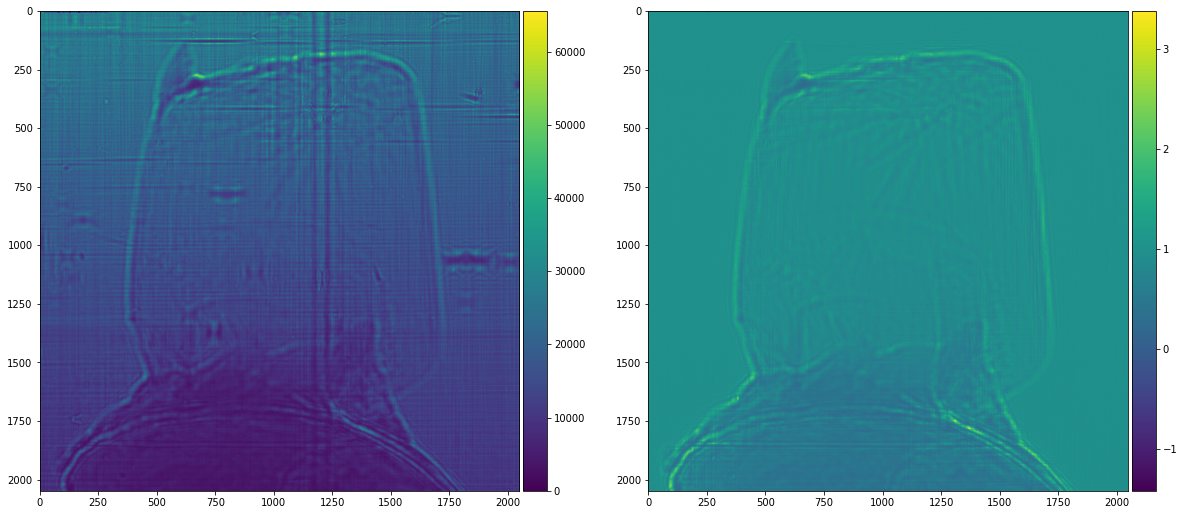

In [5]:
# Flat/Dark Correction
norm = (proj - dark)/(flat-dark)
norm[np.isinf(norm)] = 1.0
norm[np.isnan(norm)] = 1.0

print_fig([proj, norm])
proj = norm

### Calculating Fresnel Number

In [6]:
energy = 22e3
wave = CONST/energy

Fresnel = z1*pixel*pixel/(wave*z2*(z2+z1))
print(z1, z2, Fresnel)

0.0349895 0.9650605000000001 0.008383632482532152


### Phase Retrieval sscFresnel

In [7]:
# Iterative Gauss-Newton method with Conjugate Gradient method
#
# Input: Intensity
# Output: COMPLEX array -> phase_tomo = absorption_coef + 1j * phase_coef

Type = 'Lap' # Option: 'Tik' (Tikhonov regularization) or 'Lap' (Laplacian regularization)
alpha = -1   # -1 automatic computation; alpha > 0
gamma = -1   # -1 automatic computation; gamma > 0

max_iter_newton = 10 # iterative Newton method
max_iter_cg     = 20 # Conjugate Gradients method

dic = set_dictionary_phase(Type, alpha, gamma, max_iter_newton, max_iter_cg, z1, z2, pixel, energy)

initial_guess = 0*proj + 1j*0*proj # COMPLEX Initial Guess for method

Prain = sscFresnel.phase_retrieval(proj, initial_guess, dic)
Prain_abs = Prain.real[0]
Prain_phase = Prain.imag[0]

2024-07-05 14:06:12,423 - sscFresnel.fresneltypes - DEBUG - Conebeam geometry selected
2024-07-05 14:06:12,424 - sscFresnel.fresneltypes - DEBUG - No support selected.
2024-07-05 14:06:12,425 - sscFresnel.fresneltypes - DEBUG - No mask selected.


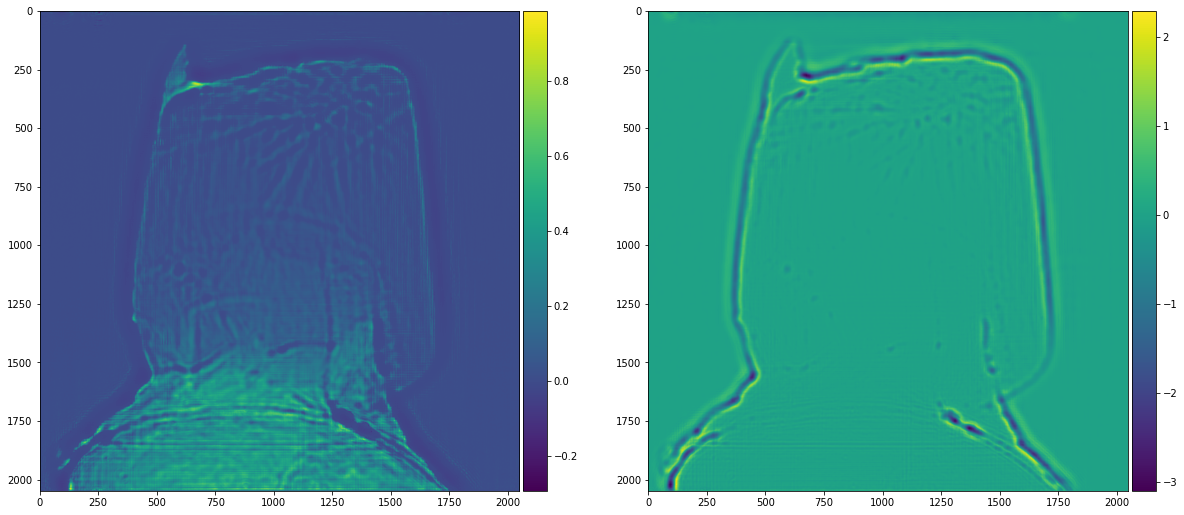

In [8]:
print_fig([Prain_abs ,Prain_phase])

### Phase Retrieval CTF

In [9]:
alpha = [1e-4, 5e-2] 
betadelta = 0.05
    
ctf = CTF(proj.shape, Fresnel, betadelta=betadelta, alpha=alpha, device=DEVICE)
result_ctf = ctf(proj)

if DEVICE == 'cuda':
    Ctf = - result_ctf.cpu() # devido ao pytorch
    Ctf = Ctf.numpy()
else:
    Ctf = - result_ctf.numpy()

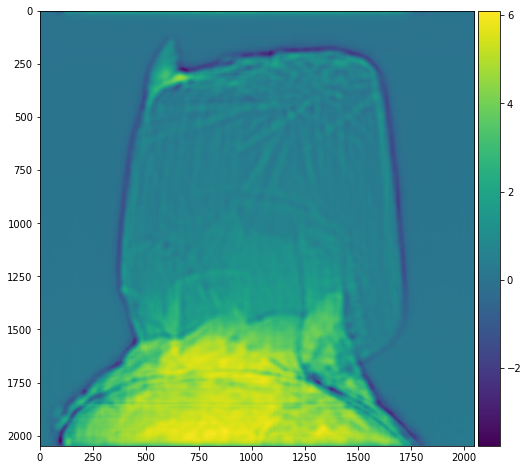

In [10]:
print_fig([Ctf])

### Phase Retrieval Tikhonov

In [11]:
alpha = [1e-4, 5e-2] 
betadelta = 0.05

tik = Tikhonov(proj.shape, Fresnel, betadelta=betadelta, alpha=alpha, device=DEVICE)
result_tik = tik(proj, max_iter=5)

if DEVICE == 'cuda':
    Tik = - result_tik.cpu() # devido ao pytorch
    Tik = Tik.numpy()
else:
    Tik = -result_tik.numpy()
    

/ibira/lnls/labs/tepui/home/camila.lages/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/ibira/lnls/labs/tepui/home/camila.lages/.local/lib/python3.9/site-packages/hotopy/phase/holographic.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = tensor(functional.x, requires_grad=False)


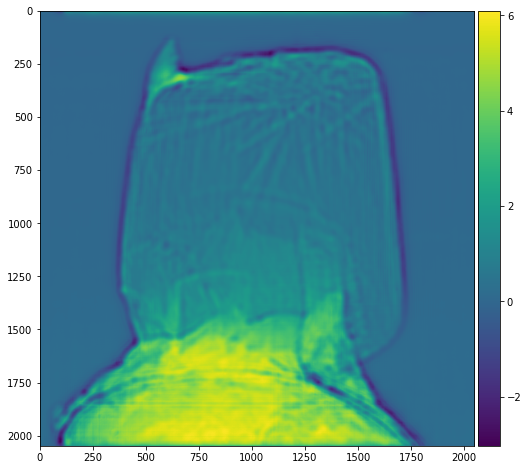

In [12]:
print_fig([Tik])

### Tomopy: Paganin

In [13]:
betadelta = 1e-3

tomopy_tomo = tomopy.prep.phase.retrieve_phase(
            np.expand_dims(proj,0),
            pixel_size=pixel_obj*100,
            dist= z2_eff*100,
            energy=energy/1e3,
            alpha=betadelta,
            ncore=CPUS,
            pad=True,
        )

Pag = -np.log(tomopy_tomo[0])

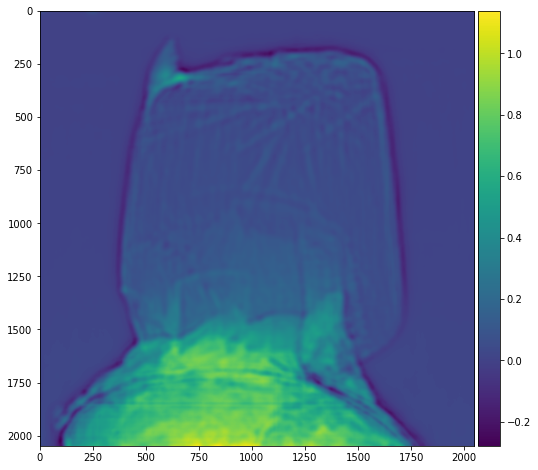

In [14]:
print_fig([Pag])

### Resolution/Sharpness


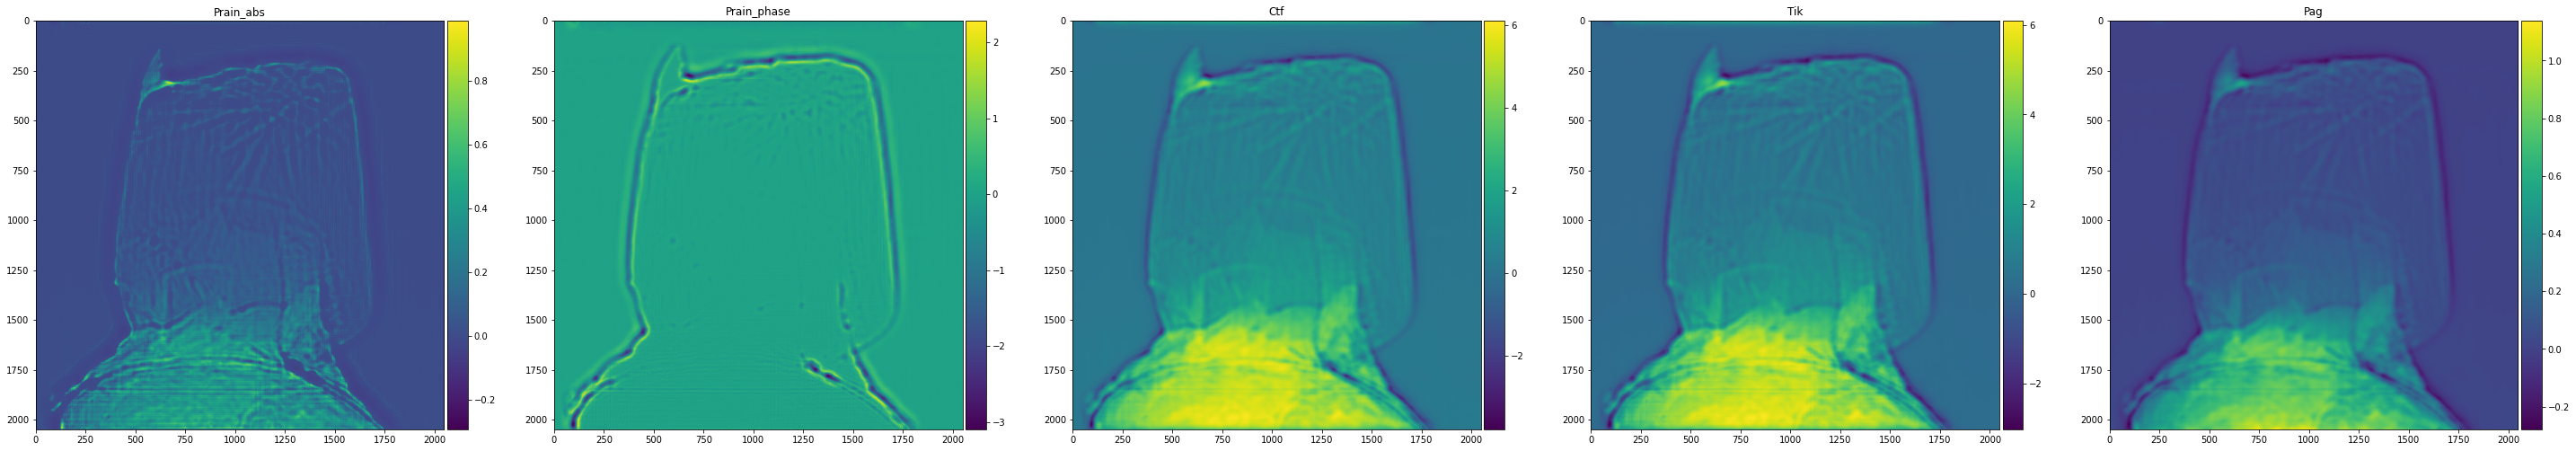

In [15]:
print_fig([Prain_abs, Prain_phase, Ctf, Tik, Pag], ['Prain_abs', 'Prain_phase', 'Ctf', 'Tik', 'Pag'])

In [16]:
def normalize_image(image_array, new_min=0, new_max=255):
    old_min = np.min(image_array)
    old_max = np.max(image_array)
    normalized_image = (image_array - old_min) * (new_max - new_min) / (old_max - old_min) + new_min
    return normalized_image.astype(np.uint8)

def measure_sharpness(image_array):
    # Ensure the input is a 2D numpy array
    if len(image_array.shape) != 2:
        raise ValueError("Input image_array must be a 2D numpy array")

    # Normalize the image array to the range 0-255
    image_array = normalize_image(image_array)
    
    # Apply the Laplacian operator
    laplacian = cv2.Laplacian(image_array, cv2.CV_64F)

    # Compute the variance of the Laplacian
    variance = laplacian.var()

    return variance

sharpness_Prain_abs = measure_sharpness(Prain_abs)
print('**Prain_abs**',sharpness_Prain_abs)

sharpness_Prain_phase = measure_sharpness(Prain_phase)
print('**Prain_phase**',sharpness_Prain_phase)

sharpness_Ctf = measure_sharpness(Ctf)
print('**Ctf**', sharpness_Ctf)

sharpness_Tik = measure_sharpness(Tik)
print('**Tik**',sharpness_Tik)

sharpness_Pag = measure_sharpness(Pag)
print('**Pag**',sharpness_Pag)


 

**Prain_abs** 32.554882775182605
**Prain_phase** 4.17126909028174
**Ctf** 5.278903240068655
**Tik** 4.939122889368618
**Pag** 0.753866376455278


	Resolution via halfbit criterion **Prain_abs**: 186.20 nm
	Resolution via halfbit criterion **Prain_phase**: 167.82 nm
	Resolution via halfbit criterion **Ctf**: 187.20 nm
	Resolution via halfbit criterion **Tik**: 184.65 nm
	Resolution via halfbit criterion **Pag**: 126.31 nm


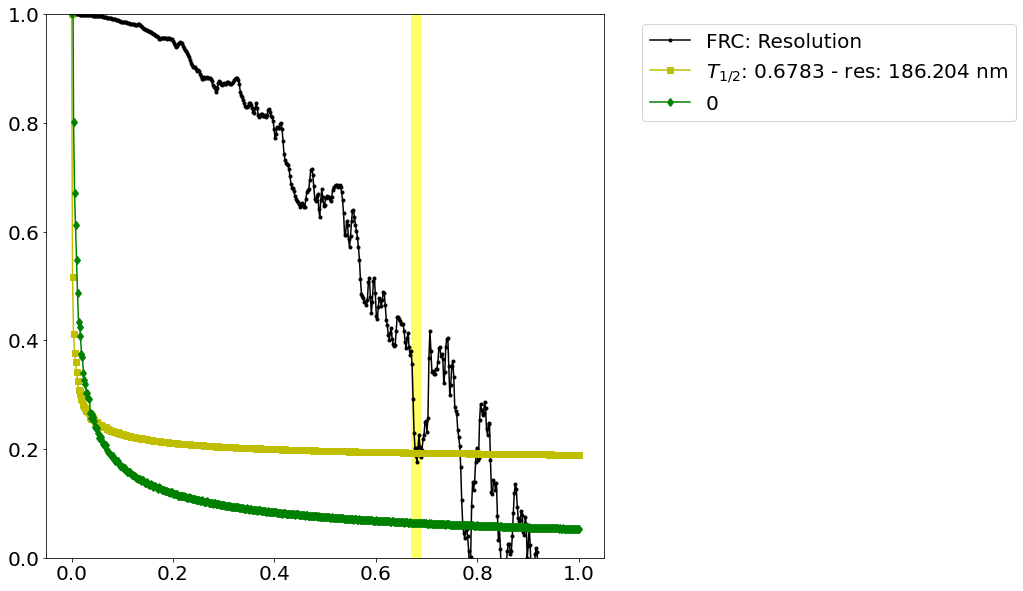

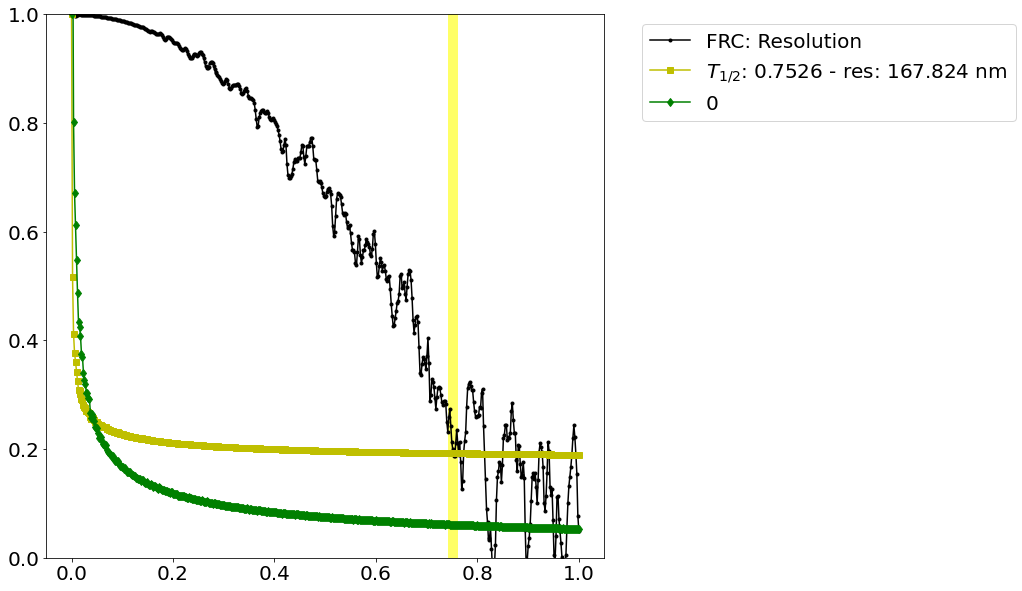

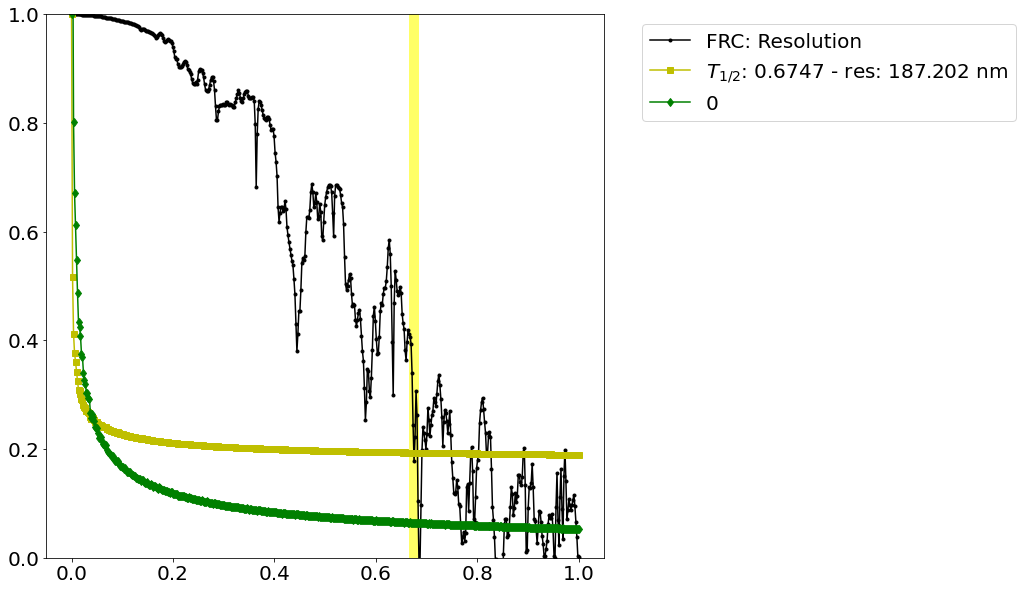

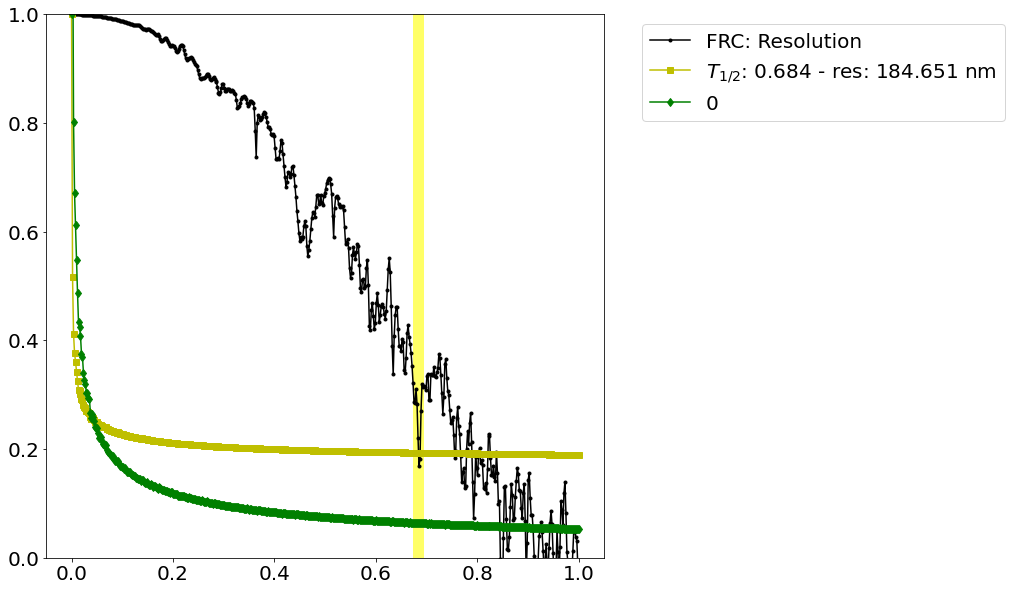

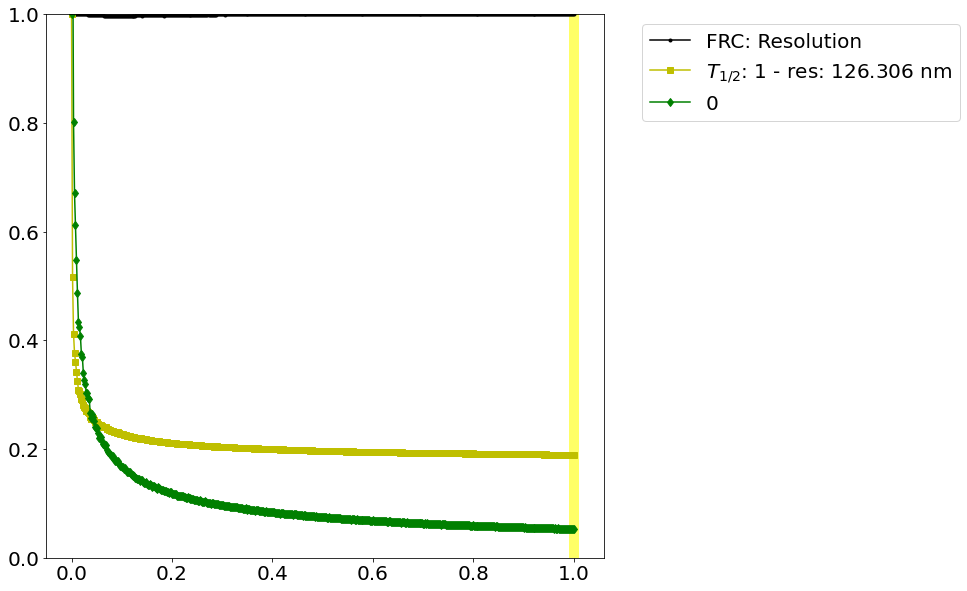

In [17]:
padding   = 0
sharpness = 0.5
radius    = 0.5

img = np.copy(Prain_abs)
img = img - img.min()
dic_resol = sscResolution.frc.computep( img , 1 ) 
print(f"\tResolution via halfbit criterion **Prain_abs**: {1e9*pixel_obj/dic_resol['x']['H']:.2f} nm")
sscResolution.frc.plot(dic_resol, {'label': "Resolution", 'unit': "nm", 'pxlsize': pixel_obj*1e9} )

img = np.copy(Prain_phase)
img = img - img.min()
dic_resol = sscResolution.frc.computep( img , 1 ) 
print(f"\tResolution via halfbit criterion **Prain_phase**: {1e9*pixel_obj/dic_resol['x']['H']:.2f} nm")
sscResolution.frc.plot(dic_resol, {'label': "Resolution", 'unit': "nm", 'pxlsize': pixel_obj*1e9} )

img = np.copy(Ctf)
img = img - img.min()
dic_resol = sscResolution.frc.computep( img , 1 ) 
print(f"\tResolution via halfbit criterion **Ctf**: {1e9*pixel_obj/dic_resol['x']['H']:.2f} nm")
sscResolution.frc.plot(dic_resol, {'label': "Resolution", 'unit': "nm", 'pxlsize': pixel_obj*1e9} )

img = np.copy(Tik)
img = img - img.min()
dic_resol = sscResolution.frc.computep( img , 1 ) 
print(f"\tResolution via halfbit criterion **Tik**: {1e9*pixel_obj/dic_resol['x']['H']:.2f} nm")
sscResolution.frc.plot(dic_resol, {'label': "Resolution", 'unit': "nm", 'pxlsize': pixel_obj*1e9} )

img = np.copy(Pag)
img = img - img.min()
dic_resol = sscResolution.frc.compute( img  ) 
print(f"\tResolution via halfbit criterion **Pag**: {1e9*pixel_obj/dic_resol['x']['H']:.2f} nm")
sscResolution.frc.plot(dic_resol, {'label': "Resolution", 'unit': "nm", 'pxlsize': pixel_obj*1e9} )


In [18]:
print(sscResolution.__version__)

0.6.1
